In [41]:
import math

from rastervision.core.box import Box
from rastervision.core.data import (RasterioCRSTransformer, StatsTransformer,
                                    XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset)

import numpy as np
import torch
from shapely.geometry import mapping, Point
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

In [44]:
import pystac_client
import stackstac

In [45]:
# Tarim basin
# 40.721508, 87.611254
# 40.574240, 87.821939

# Bab al-Mandab
bbox = Box(xmin=42.299, ymin=13.442, xmax=42.299, ymax=13.442)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [46]:
URL = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/'
catalog = pystac_client.Client.open(URL)

search = catalog.search(
    intersects=mapping(Point(42.299, 13.442)),
    collections=['VNP09GA.v002'],
    # collections=['VNP09A1.v002'],
    # collections=['VNP03MODLL.v002'],
    datetime='2023-10-19',
)
items = search.get_all_items()
len(items)

1

In [48]:
import geopandas as gpd

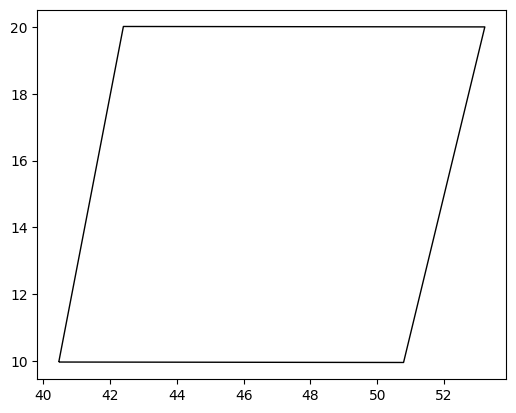

In [49]:
plt.close('all')
gpd.GeoDataFrame.from_features(items).plot(ec='k', fc='none')
plt.show()

In [ ]:
!wget https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VNP09GA.002/VNP09GA.A2023292.h22v07.002.2023293130701/VNP09GA.A2023292.h22v07.002.2023293130701.h5

In [ ]:
%%sh
wget --header="Authorization: Bearer " \
    "https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VNP09GA.002/VNP09GA.A2023292.h22v07.002.2023293130701/VNP09GA.A2023292.h22v07.002.2023293130701.h5"

In [ ]:
%pip install h5py

In [38]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
import datetime as dt
import pandas as pd
from skimage import exposure

/tmp/ipykernel_82/2258125822.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
f = h5py.File('VNP09GA.A2023292.h22v07.002.2023293130701.h5')

In [4]:
f.keys()

<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION', 'SensorAzimuth_c', 'SensorZenith_c', 'SolarAzimuth_c', 'SolarZenith_c', 'SurfReflect_I1_c', 'SurfReflect_I2_c', 'SurfReflect_I3_c', 'SurfReflect_M10_c', 'SurfReflect_M11_c', 'SurfReflect_M1_c', 'SurfReflect_M2_c', 'SurfReflect_M3_c', 'SurfReflect_M4_c', 'SurfReflect_M5_c', 'SurfReflect_M7_c', 'SurfReflect_M8_c', 'SurfReflect_QF1_c', 'SurfReflect_QF2_c', 'SurfReflect_QF3_c', 'SurfReflect_QF4_c', 'SurfReflect_QF5_c', 'SurfReflect_QF6_c', 'SurfReflect_QF7_c', 'iobs_res_c', 'land_water_mask_c', 'nadd_obs_row_1km', 'nadd_obs_row_500m', 'obscov_1km_c', 'obscov_500m_c', 'orbit_pnt_c']>

In [5]:
grids = list(f['HDFEOS']['GRIDS']) # List contents of GRIDS directory
grids

['VIIRS_Grid_1km_2D', 'VIIRS_Grid_500m_2D']

In [7]:
list(f['HDFEOS']['GRIDS']['VIIRS_Grid_1km_2D']) # List contents of 1km directory

['Data Fields', 'XDim', 'YDim']

In [13]:
list(f['HDFEOS']['GRIDS']['VIIRS_Grid_1km_2D']['Data Fields']) # List Data Fields

['Projection',
 'SensorAzimuth_1',
 'SensorZenith_1',
 'SolarAzimuth_1',
 'SolarZenith_1',
 'SurfReflect_M10_1',
 'SurfReflect_M11_1',
 'SurfReflect_M1_1',
 'SurfReflect_M2_1',
 'SurfReflect_M3_1',
 'SurfReflect_M4_1',
 'SurfReflect_M5_1',
 'SurfReflect_M7_1',
 'SurfReflect_M8_1',
 'SurfReflect_QF1_1',
 'SurfReflect_QF2_1',
 'SurfReflect_QF3_1',
 'SurfReflect_QF4_1',
 'SurfReflect_QF5_1',
 'SurfReflect_QF6_1',
 'SurfReflect_QF7_1',
 'land_water_mask_1',
 'num_observations_1km',
 'obscov_1km_1',
 'orbit_pnt_1']

In [14]:
list(f['HDFEOS INFORMATION']) # List contents of HDFEOS group

['StructMetadata.0']

In [15]:
fileMetadata = f['HDFEOS INFORMATION']['StructMetadata.0'][()].split()   # Read file metadata
fileMetadata = [m.decode('utf-8') for m in fileMetadata]                 # Clean up file metadata
fileMetadata[0:33]                                                       # Print a subset of the entire file metadata record

['GROUP=SwathStructure',
 'END_GROUP=SwathStructure',
 'GROUP=GridStructure',
 'GROUP=GRID_1',
 'GridName="VIIRS_Grid_1km_2D"',
 'XDim=1200',
 'YDim=1200',
 'UpperLeftPointMtrs=(4447802.078667,2223901.039333)',
 'LowerRightMtrs=(5559752.598333,1111950.519667)',
 'Projection=HE5_GCTP_SNSOID',
 'ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)',
 'SphereCode=-1',
 'GridOrigin=HE5_HDFE_GD_UL',
 'GROUP=Dimension',
 'OBJECT=Dimension_1',
 'DimensionName="YDim"',
 'Size=1200',
 'END_OBJECT=Dimension_1',
 'OBJECT=Dimension_2',
 'DimensionName="XDim"',
 'Size=1200',
 'END_OBJECT=Dimension_2',
 'OBJECT=Dimension_3',
 'DimensionName="dimofone"',
 'Size=1',
 'END_OBJECT=Dimension_3',
 'END_GROUP=Dimension',
 'GROUP=DataField',
 'OBJECT=DataField_1',
 'DataFieldName="num_observations_1km"',
 'DataType=H5T_NATIVE_SCHAR',
 'DimList=("YDim","XDim")',
 'MaxdimList=("YDim","XDim")']

In [16]:
h5_objs = []            # Create empty list
f.visit(h5_objs.append) # Walk through directory tree, retrieve objects and append to list
h5_objs

['HDFEOS',
 'HDFEOS/ADDITIONAL',
 'HDFEOS/ADDITIONAL/FILE_ATTRIBUTES',
 'HDFEOS/GRIDS',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/Projection',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SensorAzimuth_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SensorZenith_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SolarAzimuth_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SolarZenith_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M10_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M11_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M1_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M2_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M3_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M4_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M5_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M7_1',
 'HDFEOS/G

In [17]:
# Search for SDS with 1km or 500m grid
all_datasets = [obj for grid in grids for obj in h5_objs if isinstance(f[obj],h5py.Dataset) and grid in obj] 
all_datasets

['HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/Projection',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SensorAzimuth_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SensorZenith_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SolarAzimuth_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SolarZenith_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M10_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M11_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M1_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M2_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M3_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M4_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M5_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M7_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M8_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_QF1_1',
 'HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfRe

In [83]:
def get_band_arr(name: str) -> np.ndarray:
    band_dataset = f[name]
    scale_factor = band_dataset.attrs['scale_factor']
    fill_value = band_dataset.attrs['_FillValue']
    print(name, scale_factor, fill_value)
    band_arr = band_dataset[()]
    band_arr[band_arr == fill_value] = 0
    band_arr = band_arr * scale_factor
    return band_arr

In [69]:
from rastervision.core.data import MinMaxTransformer
tf = MinMaxTransformer()

HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M5_1 1e-04 -28672
HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M4_1 1e-04 -28672
HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M3_1 1e-04 -28672


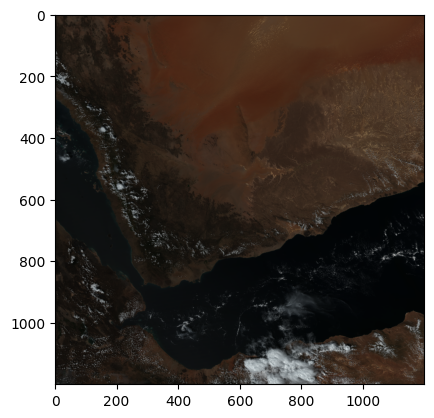

In [94]:
r = get_band_arr('HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M5_1')
g = get_band_arr('HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M4_1')
b = get_band_arr('HDFEOS/GRIDS/VIIRS_Grid_1km_2D/Data Fields/SurfReflect_M3_1')
rgb = np.dstack([r, g, b])
plt.imshow(tf.transform(rgb))
plt.show()

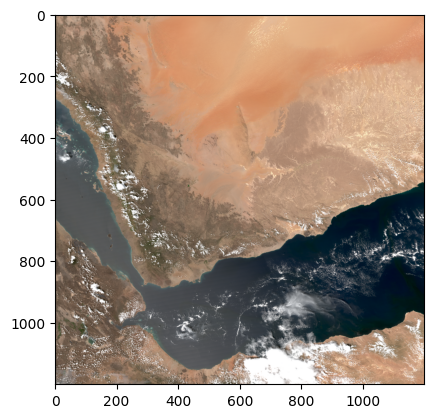

In [98]:
p2, p98 = np.percentile(rgb, (2, 98))                              # Calculate 2nd,98th percentile for updating min/max vals
rgbStretched = exposure.rescale_intensity(rgb, in_range=(p2, p98)) # Perform contrast stretch on RGB range
rgbStretched = exposure.adjust_gamma(rgbStretched, 0.5)            # Perform Gamma Correction
plt.imshow(rgbStretched)
plt.show()